In [1]:
import os
import os.path as pth
import json
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
BASE_MODEL_NAME = 'MobileNetV2-for-upload'
my_model_base = keras.applications.mobilenet_v2
my_model = my_model_base.MobileNetV2

config = {
    'is_zscore':True,
    
    # 'input_shape': (540, 960, 3),
    'aug': {
        'resize': (270, 480),
        #'resize': (297, 528),
    },
    # 'input_shape': (224, 360, 3),
    #'input_shape': (270, 480, 3),
    'input_shape': (270, 480, 3),

    'output_activation': 'softmax',
    'num_class': 1049,
    'output_size': 1049,
    
    'conv':{
        'conv_num': (0), # (3,5,3),
        'base_channel': 0, # 4,
        'kernel_size': 0, # 3,
        'padding':'same',
        'stride':'X'
    },
    'pool':{
        'type':'X',
        'size':'X',
        'stride':'X',
        'padding':'same'
    },
    'fc':{
        'fc_num': 0,
     },
    
    'activation':'relu',
    
    'between_type': 'avg',
    
    'is_batchnorm': True,
    'is_dropout': False,
    'dropout_rate': 0.5,
    
    'batch_size': 32,
    'buffer_size': 256,
    'loss': 'CategoricalCrossentropy',
    
    'num_epoch': 10000,
    'learning_rate': 1e-3,
    
    'random_state': 7777
}

In [4]:
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def resize_and_crop_func(image, label):
    result_image = tf.image.resize(image, config['aug']['resize'])
    #result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)  # crop revived.
    return result_image, label

def image_aug_func(image, label):
    pass
    return image, label

def post_process_func(image, label):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    onehot_label = tf.one_hot(label, depth=config['num_class'])
    return result_image, onehot_label

In [5]:
data_base_path = pth.join('data', 'public') 
os.makedirs(data_base_path, exist_ok=True)

In [6]:
category_csv_name = 'category.csv'
category_json_name = 'category.json'
submission_csv_name = 'sample_submisstion.csv'
train_csv_name = 'train.csv'

# train_zip_name = 'train.zip'
train_tfrecord_name = 'all_train.tfrecords'
train_tfrecord_path = pth.join(data_base_path, train_tfrecord_name)
val_tfrecord_name = 'all_val.tfrecords'
val_tfrecord_path = pth.join(data_base_path, val_tfrecord_name)
# test_zip_name = 'test.zip'
test_tfrecord_name = 'test.tfrecords'
test_tfrecord_path = pth.join(data_base_path, test_tfrecord_name)

In [7]:
train_csv_path = pth.join(data_base_path, train_csv_name)
train_df = pd.read_csv(train_csv_path)
train_dict = {k:v for k, v in train_df.values}

submission_csv_path = pth.join(data_base_path, submission_csv_name)
submission_df = pd.read_csv(submission_csv_path)
# submission_df.head()

category_csv_path = pth.join(data_base_path, category_csv_name)
category_df = pd.read_csv(category_csv_path)
category_dict = {k:v for k, v in category_df.values}
# category_df.head()

In [8]:
train_tfrecord_path

'data/public/all_train.tfrecords'

### Model

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import os
import os.path as pth
import shutil
import time
from tqdm import tqdm

import itertools
from itertools import product, combinations

import numpy as np
from PIL import Image

from IPython.display import clear_output

from multiprocessing import Process, Queue
import datetime

import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv3D, AveragePooling3D, MaxPooling3D, Dropout, \
                                    Concatenate, GlobalMaxPool3D, GlobalAvgPool3D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import max_norm

In [10]:
conv_comb_list = []
conv_comb_list += [(0,)]

base_channel_list = [0]

fc_list = [0] # 128, 0

# between_type_list = [None, 'avg', 'max']
between_type_list = ['avg']

batch_size_list = [80]

activation_list = ['relu']

# len(conv_comb_list), conv_comb_list

In [11]:
def build_cnn(config):
    input_layer = Input(shape=config['input_shape'], name='input_layer')
    pret_model = my_model(
        input_tensor=input_layer, include_top=False, weights='imagenet', 
        input_shape=config['input_shape'], pooling=config['between_type'], 
        classes=config['output_size']
    )

    pret_model.trainable = False
    
    x = pret_model.output
    
    if config['between_type'] == None:
        x = Flatten(name='flatten_layer')(x)
        
    if config['is_dropout']:
        x = Dropout(config['dropout_rate'], name='output_dropout')(x)    
            
    x = Dense(config['output_size'], activation=config['output_activation'], 
          name='output_fc')(x)
#     x = Activation(activation=config['output_activation'], name='output_activation')(x)
    model = Model(inputs=input_layer, outputs=x, name='{}'.format(BASE_MODEL_NAME))

    return model

In [13]:
model = build_cnn(config)
model.summary(line_length=150)
del model

Model: "MobileNetV2-for-upload"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_layer (InputLayer)                         [(None, 270, 480, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)                        (None, 271, 481, 3)              0                 input_layer[0][0]                                 
______________________________________________________________________________________________________________________________________________________
Conv1 (Conv2D)                                   (None, 135, 2

In [12]:
origin_train_len = len(train_df) / 5 * 4
origin_val_len = len(train_df) / 5 * 1

train_num_steps = int(np.ceil((origin_train_len)/config['batch_size']))
val_num_steps = int(np.ceil((origin_val_len)/config['batch_size']))

In [13]:
model_base_path = data_base_path
model_checkpoint_path = pth.join(model_base_path, 'checkpoint')

In [14]:
def get_lr_callback():
    lr_start   = 0.000001*10*0.5
    lr_max     = 0.0000005 * config['batch_size'] * 10*0.5
    lr_min     = 0.000001 * 10*0.5
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
     
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    return lr_callback

MobileNetV2-for-upload_resize_270_input_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
Epoch 1/6
882/882 [==============================] - 263s 298ms/step - loss: 2.2650 - acc: 0.6744 - precision: 0.9854 - recall: 0.3929 - auc: 0.9279 - val_loss: 0.7609 - val_acc: 0.8626 - val_precision: 0.9817 - val_recall: 0.7333 - val_auc: 0.9888
Epoch 2/6
882/882 [==============================] - 262s 297ms/step - loss: 0.4576 - acc: 0.9099 - precision: 0.9794 - recall: 0.8397 - auc: 0.9934 - val_loss: 0.5033 - val_acc: 0.8939 - val_precision: 0.9694 - val_recall: 0.8415 - val_auc: 0.9905
Epoch 3/6
882/882 [==============================] - 262s 297ms/step - loss: 0.2804 - acc: 0.9378 - precision: 0.9751 - recall: 0.9089 - auc: 0.9954 - val_loss: 0.4380 - val_acc: 0.9059 - val_precision: 0.9630 - val_recall: 0.8718 - val_auc: 0.9905
Epoch 4/6
882/882 [==============================] - 262s 297ms/step - loss: 0.2161 - acc: 0.9496 - precision: 0.9737 - recall: 0.9326 - 

Epoch 12/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000
Epoch 00012: val_loss improved from 0.18298 to 0.18215, saving model to data/public/checkpoint/MobileNetV2-for-upload_resize_270_input_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000012-0.182148-0.003543.hdf5
882/882 [==============================] - 298s 338ms/step - loss: 0.0035 - acc: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000 - val_loss: 0.1821 - val_acc: 0.9604 - val_precision: 0.9770 - val_recall: 0.9526 - val_auc: 0.9951
Epoch 13/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000
Epoch 00013: val_loss improved from 0.18215 to 0.18025, saving model to data/public/checkpoint/MobileNetV2-for-upload_resize_270_input_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000013-0.180249-0

881/882 [============================>.] - ETA: 0s - loss: 6.0680e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00043: val_loss did not improve from 0.17435
882/882 [==============================] - 298s 338ms/step - loss: 7.2724e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1771 - val_acc: 0.9637 - val_precision: 0.9759 - val_recall: 0.9586 - val_auc: 0.9949
Epoch 44/10000
881/882 [============================>.] - ETA: 0s - loss: 6.1654e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00044: val_loss did not improve from 0.17435
882/882 [==============================] - 299s 339ms/step - loss: 7.7674e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1767 - val_acc: 0.9641 - val_precision: 0.9761 - val_recall: 0.9584 - val_auc: 0.9948
Epoch 45/10000
881/882 [============================>.] - ETA: 0s - loss: 6.0824e-04 - acc: 1.0000 - precision: 1.0000 - recall

Epoch 78/10000
881/882 [============================>.] - ETA: 0s - loss: 4.4016e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00078: val_loss did not improve from 0.17394
882/882 [==============================] - 299s 338ms/step - loss: 5.5888e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1754 - val_acc: 0.9640 - val_precision: 0.9764 - val_recall: 0.9594 - val_auc: 0.9949
Epoch 79/10000
881/882 [============================>.] - ETA: 0s - loss: 4.3233e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00079: val_loss did not improve from 0.17394
882/882 [==============================] - 299s 339ms/step - loss: 5.1506e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1757 - val_acc: 0.9640 - val_precision: 0.9763 - val_recall: 0.9593 - val_auc: 0.9949
Epoch 80/10000
881/882 [============================>.] - ETA: 0s - loss: 4.3555e-04 - acc: 1.0000 - precision: 

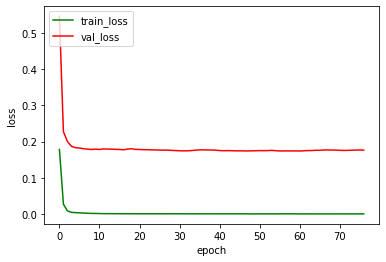

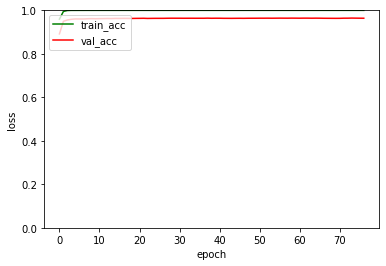

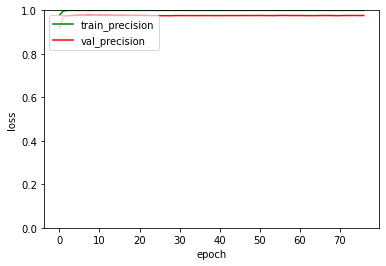

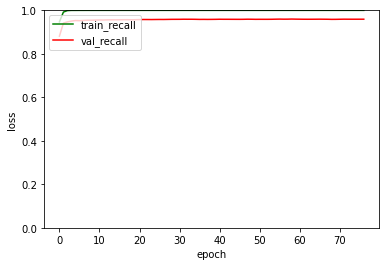

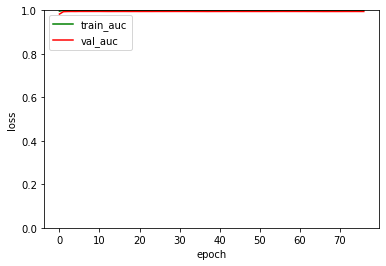

In [17]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])
    base += '_input_{}'.format(config['input_shape'][0])
    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # dataset = dataset.cache()
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(config['buffer_size'])
    dataset = dataset.batch(config['batch_size'])
    dataset = dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.TFRecordDataset(val_tfrecord_path, compression_type='GZIP')
    val_dataset = val_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.shuffle(config['buffer_size'])
    val_dataset = val_dataset.batch(config['batch_size'])
    val_dataset = val_dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.cache()
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
#     model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
#                   metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    if pth.isdir(model_path) and len([_ for _ in os.listdir(model_path) if _.endswith('hdf5')]) >= 1:
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])

        model_chk_name = sorted(os.listdir(model_path))[-1]
        initial_epoch = int(model_chk_name.split('-')[0])
        model.load_weights(pth.join(model_path, model_chk_name))
    else:
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        PRE_TRAIN_EPOCH = 6
        model.fit(
            x=dataset, epochs=PRE_TRAIN_EPOCH, # train only top layers for just a few epochs.
            validation_data=val_dataset, shuffle=True,
            #callbacks = [checkpointer, es], #batch_size=config['batch_size']
            initial_epoch=initial_epoch,
            # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
            verbose=1)
        
        for i, layer in enumerate(model.layers):
            print(i, layer.name)
        
        for layer in model.layers[:135]:
            layer.trainable = False
        for layer in model.layers[135:]:
            layer.trainable = True
        
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        initial_epoch=PRE_TRAIN_EPOCH
            
    # ### Freeze first layer
    # conv_list = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)]
    # conv_list[0].trainable = False
    # # conv_list[1].trainable = False

    os.makedirs(model_path, exist_ok=True)
    model_filename = pth.join(model_path, '{epoch:06d}-{val_loss:0.6f}-{loss:0.6f}.hdf5')
    checkpointer = ModelCheckpoint(
        filepath=model_filename, verbose=1, 
        period=1, save_best_only=True, 
        monitor='val_loss'
    )
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=16)

    hist = model.fit(
        x=dataset, epochs=config['num_epoch'], 
        validation_data=val_dataset, shuffle=True,
        callbacks = [get_lr_callback(), checkpointer, es], #batch_size=config['batch_size']
        initial_epoch=initial_epoch,
        # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
        verbose=1
    )

    model_analysis_path = model_path.replace('checkpoint', 'analysis')
    visualization_path = pth.join(model_analysis_path,'visualization')
    os.makedirs(visualization_path, exist_ok=True)
    
    print()
    # clear_output()        
    for each_label in ['loss', 'acc', 'precision', 'recall', 'auc']:
        fig, ax = plt.subplots()
        ax.plot(hist.history[each_label], 'g', label='train_{}'.format(each_label))
        ax.plot(hist.history['val_{}'.format(each_label)], 'r', label='val_{}'.format(each_label))
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        if not each_label == 'loss':
            plt.ylim(0, 1)
        plt.show()
        filename = 'learning_curve_{}'.format(each_label)
#             fig.savefig(pth.join(visualization_path, filename), transparent=True)
        plt.cla()
        plt.clf()
        plt.close('all')

    np.savez_compressed(pth.join(visualization_path, 'learning_curve'), 
                        loss=hist.history['loss'], 
                        val_loss=hist.history['val_loss'],
                        acc=hist.history['acc'], 
                        val_acc=hist.history['val_acc'],
                        precision=hist.history['precision'], 
                        vaval_precisionl_mae=hist.history['val_precision'],  
                        recall=hist.history['recall'],
                        val_recall=hist.history['val_recall'],
                        auc=hist.history['auc'],
                        val_auc=hist.history['val_auc']
                        )

    model.save(pth.join(model_path, '000000_last.hdf5'))
    K.clear_session()
    del(model)
    
    model_analysis_base_path = pth.join(model_base_path, 'analysis', model_name) 
    with open(pth.join(model_analysis_base_path, 'config.json'), 'w') as f:
        json.dump(config, f)

    chk_name_list = sorted([name for name in os.listdir(model_path) if name != '000000_last.hdf5'])
    for chk_name in chk_name_list[:-5]:
        os.remove(pth.join(model_path, chk_name))
    # clear_output()

### Inference

In [15]:
image_feature_description_for_test = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    # 'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_for_test(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description_for_test)

def map_func_for_test(target_record):
    img = target_record['image_raw']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img

def resize_and_crop_func_for_test(image):
    result_image = tf.image.resize(image, config['aug']['resize'])
    #result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)  # revive
    return result_image

def post_process_func_for_test(image):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    return result_image

In [16]:
submission_base_path = pth.join(data_base_path, 'submission')
os.makedirs(submission_base_path, exist_ok=True)

In [17]:
preds = []
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])
    base += '_input_{}'.format(config['input_shape'][0])
    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(_parse_image_function_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(map_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(resize_and_crop_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(config['batch_size'])
    test_dataset = test_dataset.map(post_process_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    model_chk_name = sorted(os.listdir(model_path))[-1]
    initial_epoch = int(model_chk_name.split('-')[0])
    model.load_weights(pth.join(model_path, model_chk_name))

    preds = model.predict(test_dataset, verbose=1)
    
    #pred_labels = np.argmax(preds, axis=1)
    #pred_probs = np.array([pred[indice] for pred, indice in zip(preds, pred_labels)])
    
    # argmax --> top3
    pred_labels = np.argsort(-preds)
    
    submission_csv_path = pth.join(data_base_path, submission_csv_name)
    submission_df = pd.read_csv(submission_csv_path)
    
    merged_df = []
    
    RANK_TO_SAVE = 5
    for i in range(RANK_TO_SAVE):
        tmp_df = submission_df.copy()
        
        tmp_labels = pred_labels[:, i]
        tmp_df['landmark_id'] = tmp_labels
        tmp_df['conf'] = np.array([pred[indice] for pred, indice in zip(preds, tmp_labels)])
        merged_df.append(tmp_df)
    
    submission_df = pd.concat(merged_df)
    
    #submission_df['landmark_id'] = pred_labels
    #submission_df['conf'] = pred_probs

    today_str = datetime.date.today().strftime('%Y%m%d')
    result_filename = '{}.csv'.format(model_name)
    submission_csv_fileaname = pth.join(submission_base_path, '_'.join([today_str, result_filename]))
    submission_df.to_csv(submission_csv_fileaname, index=False)

MobileNetV2-for-upload_resize_270_input_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
      1/Unknown - 0s 50us/stepWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0134s vs `on_predict_batch_end` time: 0.1895s). Check your callbacks.
475/475 [==============================] - 104s 219ms/step
